<h1>Project 3: OpenStreetMap</h1>

<h1>Map area</h1>
<p>I have chosen to explore the data for the city of <a href="https://en.wikipedia.org/wiki/Leiden">Leiden</a> in the Netherlands. Leiden is the city where I was born and lived for most of my life. As no default map was available, I created a customized map based on the county of Leiden. This map entails Leiden and it surroundings cities and towns.</p>

<h1>Exploring the data</h1>
<p>To explore and audit the data, I created a smaller sample file (3.6 MB) with the code provided.
<ol>
<li>I scrolled through this sample file (xml file) in a text editor.</li>
<li>I ran the two queries below to explore the available keys and the values for particular keys.</li>
<li>I also ran the data.py code for the sample file to be able to explore the data in csv format.</li>
</ol>

```python
def explore_keys(file):
    context = ET.iterparse(file, events=('end',))
    list = []
    for event, elem in context:
        for child in elem:
            if child.tag == 'tag':
                if child.attrib['k'] not in list:
                    list.append(child.attrib['k'])
    return list```    

```python
def explore_values(file, key):
    context = ET.iterparse(file, events=('end',))
    list=[]
    for event, elem in context:
        for child in elem:
            if child.tag == 'tag':
                if child.attrib['k'] == key:
                    if child.attrib['v'] not in list:
                        list.append(child.attrib['v'])
    return list```

<h1>Data problems</h1>
<p>I mostly focused on exploring three different keys, namely streetname ('addr:street'), postcode ('addr:postcode') and phone number ('phone').</p>

<h2>Streetnames</h2>
<p>Unlike the streetnames for the US, the streetnames in this dataset were pretty neat. No abbreviations were found, which was expected as it is less common to abbreviate roadtypes like 'straat' (street), 'laan' (avenue), 'weg' (road) etc in Dutch. Luckily as Dutch streetnames have a different set up as English ones, for example 'Kennedy Avenue' would be 'Kennedylaan' in Dutch. The streettypes are part of the name which would made it more difficult to isolate the streettype part of a streetname. </p> 
<p>I however noticed that when writing the data to csv some streetnames got obscured, 'Boudewijn Büchpad' became 'Boudewijn BÃ¼chpad'. When the csv was however uploaded to the database I found that the streetnames were printed correctly, so I decided no cleaning was needed.</p>

<h2>Postcodes</h2>
<p>A postcode in the Netherlands consist of 4 integers, a space and 2 capital letters (#### AA). Eventhough I already knew that my dataset had more data than just for the city of Leiden, this also became clear as postcodes outside the Leiden range (2300–2334) were found. Most values in the sample file had a ####AA format. I therefore decided to clean the data to reflect the correct format by using the code below.</p>
<p>Examples: 
<ul>
<li>2321XL to 2321 XL</li>
<li>2324 to XXXX AA</li>
</ul></p>

<p>Used code:</p>
```python
POSTCODE = re.compile(r'^(\d{4}) ([A-Z]{2})')

def fix_postcode(postcode):
    if POSTCODE.search(postcode) is None:
        if len(postcode)==6:
            return postcode[:4] + ' ' + postcode[4:7]
        # return placeholder for postcodes which are incomplete, these entries can then easily identified in sql
        else:
            return 'XXXX AA'
    else:
        return postcode```

<h2>Phone numbers</h2>
<p>Exploring the data I found many different formats were used for phonenumbers. Numbers start with an area code (fe 071 for Leiden) or the mobile phone code (06). When a country code is used the prevailing 0 in these codes should not be dialed. The correct phone format including the country code is therefore +31 ## ### ####. So 071 531 9012 becomes +31 71 576 871 9012. The code beneath was used to clean the phone numbers.<p>

<p>Examples: 
<ul>
<li>071 531 9012 to +31 71 531 9012</li>
<li>31-(0)71-5768279 to +31 71 576 8279
<li>0713014920 to +31 71 301 4920</li>
</ul></p>

<p>Used code:</p>
```python
PHONE = re.compile(r'(\+31) (\d{2}) (\d{3}) (\d{4})$')

def fix_phone_num(phone_num): 
    # if the phonenumber does is not in the correct format
    if PHONE.search(phone_num) is None:    
        # remove dashes
        if "-" in phone_num:
            phone_num = phone_num.replace('-','')
        # remove spaces
        if " " in phone_num:
            phone_num = phone_num.replace(' ','')
        # remove (0)
        if "(0)" in phone_num:
            phone_num = phone_num.replace('(0)','')
        # replace starting 0 with +31
        if phone_num[0] == '0':
            phone_num = '+31' + phone_num[1:]
        # replace starting 3 with +31
        if phone_num[0] == '3':
            phone_num = '+31' + phone_num[2:]
        # add country code to number
        if phone_num[0] == '7':
            phone_num = '+31' + phone_num[0:] 
        # remove extra 0 after country code
        if '+310' in phone_num:
            phone_num = phone_num[:3] + phone_num[4:]
        # put phonenumber in correct format
        return phone_num[:3] + ' ' + phone_num[3:5] + ' ' + phone_num[5:8] + ' ' + phone_num[8:12]
    else:
        return phone_num```

<h2>Other problems</h2>
<p>When exploring the created ways_tags.csv I noticed that some keys with a colon showed up as type 'regular'. Did surprised me a bit as I used LOWER_COLON in my shape_element code which seemed to work fine in the case study. When exploring the entries further, I noticed that these key names contain either a capital letter or a number which explains why they were not splitted in a key and type value. As there were only a couple of entries in the sample file and they were not displaying interesting values, I decided to leave these values as they are.</p> 

<h1>Data overview</h1>

In [1]:
#imports
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Disable warning
pd.options.mode.chained_assignment = None

In [2]:
# create connection with database
conn = sqlite3.connect('leiden.db')
c = conn.cursor()

<h2>File sizes</h2>

In [3]:
# used in sorted_list to get tuples sorted by size of files
def getKey(item):
    return item[1]

dirpath = '/Users/rianne/Desktop/udacity/Lessons/Lesson 3/project'

files_list = []
for path, dirs, files in os.walk(dirpath):
    files_list.extend([(filename, os.path.getsize(os.path.join(path, filename))) for filename in files])
    sorted_list = sorted(files_list, key=getKey, reverse=True)

# removing jupyter notebook and images from list by using [:-4]
for filename, size in sorted_list[:-4]:
    size = size/1000000.0
    if size > 100:
        print '{:.<20s} {:.4}'.format(filename,size), 'MB'
    elif size > 10:
        print '{:.<20s} {:.3}'.format(filename,size), 'MB'
    else:
        print '{:.<20s} {:.2}'.format(filename,size), 'MB'

leiden.osm.......... 360.1 MB
leiden.db........... 222.4 MB
nodes.csv........... 113.8 MB
ways_nodes.csv...... 42.4 MB
nodes_tags.csv...... 35.0 MB
ways_tags.csv....... 32.4 MB
ways.csv............ 13.7 MB


<h2>Number of nodes</h2>

In [4]:
query = 'SELECT count(*) FROM nodes'
c.execute(query)
results = c.fetchall()
print results[0][0]

1356988


<h2>Number of ways</h2>

In [5]:
query = 'SELECT count(*) FROM ways'
c.execute(query)
results = c.fetchall()
print results[0][0]

216671


<h2>Number of unique users</h2>

In [6]:
query = 'SELECT count(distinct x.uid) FROM (SELECT uid FROM ways UNION ALL SELECT uid FROM nodes) as x'
c.execute(query)
results=c.fetchall()
print results[0][0]

635


<h2>Top 10 contributing users</h2>

In [7]:
# Find top 10 users and their number of contributions
query = '''
SELECT 
  x.user, count(*) as num
FROM 
  (SELECT user, timestamp FROM ways UNION ALL SELECT user, timestamp FROM nodes) as x 
GROUP BY 
  x.user 
ORDER BY 
  num DESC 
LIMIT 10'''

c.execute(query)
results = c.fetchall()

# create df in order to display data nicely
df = pd.DataFrame(results)
users_df = df.rename(columns={0:'User', 1:'Contributions'})
users_df

,User,Contributions
0,stroet43,410305
1,It's so funny_BAG,360898
2,opani_BAG,205273
3,3dShapes,183037
4,Computerfreaked_BAG2,87542
5,Sander H,38518
6,Chiuaua_BAG,30296
7,padvinder,22786
8,DutchMapper,22779
9,CJTmmr,17180


<h1>Additional explorations</h1>

<h2>Contributors & their sources</h2>
<p>The top 10 contributors found above, contributed 88% of the nodes and ways in this database. The top 5 even contributed 79% of all entries. On the other hand 351 of the 635 contributors only made 10 or less contributions. This made me wonder how these top contributors could contribute so many.</p> 

In [8]:
# total contributions of top 10 contributors
query10 = '''
SELECT 
  sum(num) 
FROM
  (SELECT 
     x.user, count(*) as num 
   FROM 
     (SELECT user FROM ways UNION ALL SELECT user FROM nodes) as x 
   GROUP BY 
     x.user 
   ORDER BY 
     num DESC 
   LIMIT 10)'''

c.execute(query10)
a = c.fetchall()
a = a[0][0]

# total contributions of top 5 contributors
query5 = '''
SELECT 
  sum(num) 
FROM
  (SELECT 
     x.user, count(*) as num 
   FROM 
     (SELECT user FROM ways UNION ALL SELECT user FROM nodes) as x 
   GROUP BY 
     x.user 
   ORDER BY 
     num DESC 
   LIMIT 5)'''

c.execute(query5)
b = c.fetchall()
b = b[0][0]

# total contributions in database
query = '''
SELECT 
  count(x.uid) 
FROM 
  (SELECT uid FROM ways UNION ALL SELECT uid FROM nodes) as x'''
c.execute(query)
total = c.fetchall()

print '% contributions by top 10 contributors:', round((float(a)/ total[0][0]),2)
print '% contributions by top 5 contributors:', round((float(b)/ total[0][0]),2)

% contributions by top 10 contributors: 0.88
% contributions by top 5 contributors: 0.79


In [9]:
query = '''
SELECT 
  count(*)
FROM 
  (SELECT
     x.user as user, count(*) as num 
   FROM 
     (SELECT user FROM ways UNION ALL SELECT user FROM nodes) as x
   GROUP BY 
     x.user
   HAVING 
     num <= 10)'''

c.execute(query)
results=c.fetchall()
print 'Number of contributors who made 10 or less contributions:', results[0][0]

Number of contributors who made 10 or less contributions: 351


<p>So I decided to look when these top contributors made their first and last contribution. The users with 'BAG' in their names seemed to be only active in 2014 and some only for a couple of months or even a couple of weeks. How can they make so many contributions? On the Wiki for OpenStreetMap I found <a href='http://wiki.openstreetmap.org/wiki/BAGimport'>this article</a> about how to import data from BAG (Basisregistratie Adressen en Gebouwen, Registration of addresses and building). This article also made clear that 3dShapes did something similar before 2014. These are databases that were imported to OpenStreetMaps. So this automatically uploading of data explains why some users have so many contributions and why the format of entries is overall pretty consistent (less human error when added).</p>

In [10]:
# Find top 10 users, their number of contributions and their first and last contribution
query = '''
SELECT 
  x.user, count(*) as num, min(date(substr(timestamp,1,19))), max(date(substr(timestamp,1,19)))
FROM 
  (SELECT user, timestamp FROM ways UNION ALL SELECT user, timestamp FROM nodes) as x 
GROUP BY 
  x.user 
ORDER BY 
  num DESC 
LIMIT 10'''

c.execute(query)
results = c.fetchall()
# create df in order to display data nicely
df = pd.DataFrame(results)
users_df = df.rename(columns={0:'User', 1:'Contributions', 2:'First contribution', 3:'Last contribution'})
users_df

,User,Contributions,First contribution,Last contribution
0,stroet43,410305,2008-05-03,2017-02-26
1,It's so funny_BAG,360898,2014-01-02,2014-06-05
2,opani_BAG,205273,2014-05-11,2014-06-02
3,3dShapes,183037,2010-02-15,2011-01-30
4,Computerfreaked_BAG2,87542,2014-03-19,2014-06-04
5,Sander H,38518,2013-08-11,2017-07-11
6,Chiuaua_BAG,30296,2014-05-03,2014-05-21
7,padvinder,22786,2012-12-20,2017-02-24
8,DutchMapper,22779,2016-04-11,2017-07-17
9,CJTmmr,17180,2014-06-01,2017-06-25


<p>There are 1,573,659 ways and nodes in the Leiden database. 333,442 of these are sources by BAG and 15,168 by 3dShapes. 22% of the database is sourced by one of these two sources and no other big sources are used. The next two sources (ProRail and Arriva) are public transport companies.</p>

In [11]:
# find total number of ways and nodes in database
query_total = 'SELECT count(*) FROM (SELECT id FROM nodes UNION ALL SELECT id FROM ways)'
c.execute(query_total)
results_total = c.fetchall()
print "Number of ways and nodes in database:", results_total[0][0]

# find the different types of sources used and their frequency
query = '''
SELECT 
  value, count(*) as num
FROM
  (SELECT * FROM ways_tags UNION ALL SELECT * FROM nodes_tags) 
WHERE 
  key = 'source'
GROUP BY
  value
ORDER BY
  num DESC '''

c.execute(query)
results=c.fetchall()
df = pd.DataFrame(results)
sources_df = df.rename(columns={0:'Source', 1:'Frequency'})

# find % 
print "% of nodes and ways sources by BAG and 3dShapes:", \
  round((sources_df.at[0,'Frequency'] + sources_df.at[1,'Frequency']) / float(results_total[0][0]),4)

sources_df.head(5)

Number of ways and nodes in database: 1573659
% of nodes and ways sources by BAG and 3dShapes: 0.2215


,Source,Frequency
0,BAG,333422
1,3dShapes,15168
2,ProRail,994
3,Arriva,521
4,survey,309


<p>If we look at the top 1 contributor (stroet43) 119,977 of his 410,305 contributions are sourced by BAG. For the majority of his/her entries no source tag is available. If nodes have no tags it can either be that they are forgotten to be added or the node is part of a way (streets, waterways etc) or relation which does not require tags. But I am still wondering where the information for these nodes is coming from.</p>

In [12]:
# find sources used by top 1 contributor, stroet43
query = '''
SELECT
  value, count(*) as num
FROM
  (SELECT * FROM ways_tags UNION ALL SELECT * FROM nodes_tags)
WHERE 
  id IN (SELECT id FROM (SELECT id, user FROM ways UNION ALL SELECT id, user FROM nodes) WHERE user = "stroet43") 
AND
  key = 'source'
GROUP BY
  value
ORDER BY
  num DESC
'''

c.execute(query)
results = c.fetchall()
df = pd.DataFrame(results)
source_df = df.rename(columns={0:'Source', 1:'Frequency'})
source_df.head(5)

,Source,Frequency
0,BAG,119977
1,survey,69
2,3dShapes,31
3,Arriva,4
4,Yahoo,3


<h2>City boundaries</h2>
<p>As the lat and lon coordinates of every node is given I thought it would be nice to plot these in a scatterplot and see if it showed up as expected (<a href="https://goo.gl/maps/mBUMRvSM5dE2">Leiden boundary</a>). I started with the city boundaries (admin_level = 8, <a href="http://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#11_admin_level_values_for_specific_countries">source</a>). See plot below, as the database contains for also data for the surroundings of Leiden, we see multiple city boundaries.</p>

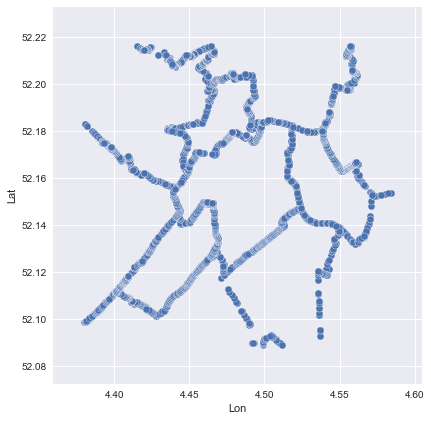

In [13]:
# find city boundaries
query = '''
SELECT 
  nodes.lat, nodes.lon
FROM 
  nodes
INNER JOIN
  (SELECT 
     w_n.node_id as node_id 
   FROM
     (SELECT id FROM ways_tags WHERE key = 'admin_level' AND value='8') as w
   LEFT JOIN
     ways_nodes as w_n
   ON w.id = w_n.id) as ways_
ON 
ways_.node_id = nodes.id
'''

c.execute(query)
results = c.fetchall()
df = pd.DataFrame(results)
df_city = df.rename(columns={0:"Lat",1: "Lon"})

# plot city boundaries
sns.pairplot(df_city, x_vars='Lon', y_vars='Lat', size=6)
plt.show()

<p>Not very scientific, but based on observation I have narrowed the area that is shown, so the city boundaries of Leiden are the focus. I think that with help of relations you probably could get the nodes that made up only the city boundaries for Leiden, but I did not explore this further for now. The shape of the city looks as expected.</p>

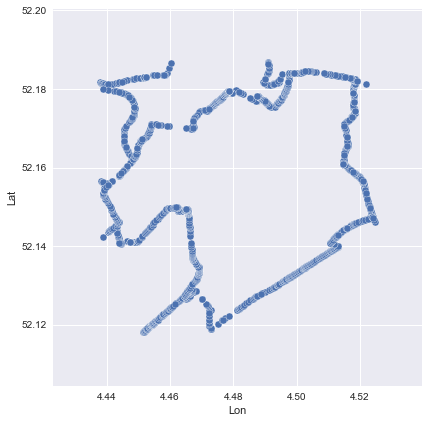

In [14]:
# isolate city boundaries for Leiden
df_leiden = df_city[(df_city.Lon>=4.438) & (df_city.Lon<=4.525) & (df_city.Lat>=52.118) & (df_city.Lat<=52.187)]
sns.pairplot(df_leiden, x_vars='Lon', y_vars='Lat', size=6)
plt.show()

<h2>Accommodations</h2>
<p>According to <a href="https://www.booking.com/searchresults.html?aid=336408&label=leiden-eQY7Tt_tNuHhM*fOEHaJyQS201212258357%3Apl%3Ata%3Ap135%3Ap2%3Aac%3Aap1t1%3Aneg%3Afi%3Atiaud-285284111246%3Akwd-12082263405%3Alp9032131%3Ali%3Adec%3Adm&sid=47e09a33541d6055c22d59c7fb294706&sb=1&src=city&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Fcity%2Fnl%2Fleiden.html%3Faid%3D336408%3Blabel%3Dleiden-eQY7Tt_tNuHhM%252AfOEHaJyQS201212258357%253Apl%253Ata%253Ap135%253Ap2%253Aac%253Aap1t1%253Aneg%253Afi%253Atiaud-285284111246%253Akwd-12082263405%253Alp9032131%253Ali%253Adec%253Adm%3Bsid%3D47e09a33541d6055c22d59c7fb294706%3Binac%3D0%26%3B&ssne=Leiden&ssne_untouched=Leiden&city=-2148516&checkin_month=&checkin_monthday=&checkin_year=&checkout_month=&checkout_monthday=&checkout_year=&room1=A%2CA&no_rooms=1&group_adults=2&group_children=0&genius_rate=1">Booking.com</a> Leiden has 35 places for accommodations (it shows 41 but 6 of those are in Oegstgeest a neigbouring town). So I was wondering how many of these are available in the OpenStreetMap database.</p>
<p>There are 20 <a  href="https://wiki.openstreetmap.org/wiki/Map_Features#Tourism">hotels</a> in Leiden according to the database, which is lower than the number Booking.com has provided us. However as we also take into account other types of accommodation (like guest houses, motels and hostels) we find 82 places. As a bigger area than Leiden is covered in the database, I tried to find out how many of these places are located within the city boundaries. </p>
<p>First by trying to find out if they have a city tag. Only 9 of the 82 locations have a city tag and of these only 4 are indicated as being in Leiden. After that I tried to do the same for postcodes, but only 6 accommodations in the dataset have a postcode tag (of which 2 are in Leiden, postcode between 2300 and 2334).</p> 

In [16]:
# find hotels
query = ' SELECT count(id) FROM nodes_tags WHERE key = "tourism" AND value = "hotel"'

c.execute(query)
results = c.fetchall()
print "Hotels in Leiden database:", results[0][0]

Hotels in Leiden database: 20


In [17]:
# find all types of accommodation
query = '''
SELECT 
  count(id)
FROM 
  nodes_tags 
WHERE 
  key = "tourism" AND (value = "hotel" OR value="guest_house" OR value="hostel" OR value="motel")'''

c.execute(query)
results = c.fetchall()
print "Accommodations in Leiden database:", results[0][0]

Accommodations in Leiden database: 82


In [18]:
# find accommodation that has a city tag
query1 = '''
SELECT 
  count(*) 
FROM 
  nodes_tags
INNER JOIN 
  (SELECT id FROM nodes_tags WHERE key = "tourism" AND 
   (value = "hotel" OR value="guest_house" OR value="hostel" OR value="motel")) as hotels
ON 
  hotels.id = nodes_tags.id
WHERE 
  key = 'city'
'''

c.execute(query1)
results = c.fetchall()
print "Accommodation that has a city tag:", results[0][0]

# find accommodation that has a city tag for Leiden
query2 = '''
SELECT 
  count(*) 
FROM 
  nodes_tags
INNER JOIN 
  (SELECT id FROM nodes_tags WHERE key = "tourism" 
   AND (value = "hotel" OR value="guest_house" OR value="hostel" OR value="motel")) as hotels
ON 
  hotels.id = nodes_tags.id
WHERE 
  key = 'city' AND value = 'Leiden'
'''

c.execute(query2)
results=c.fetchall()
print "Accommodation that is located in Leiden:", results[0][0]

Accommodation that has a city tag: 9
Accommodation that is located in Leiden: 4


In [19]:
# find accommodation that has a postcode
query = '''
SELECT 
  value 
FROM 
  nodes_tags
INNER JOIN 
  (SELECT id FROM nodes_tags WHERE key = "tourism" 
   AND (value = "hotel" OR value="guest_house" OR value="hostel" OR value="motel")) as hotels
ON 
  hotels.id = nodes_tags.id
WHERE 
  key = 'postcode'
'''

c.execute(query)
results = c.fetchall()
#print results
print "Accommodation that has a postcode tag:", len(results)

Accommodation that has a postcode tag: 6


<h3>Using lat & lon</h3>
<p>Another way to determine the location of an accommodation would be looking if its lat and lon coordinates falls within the city of Leiden. I found that 12 hotels and 33 guest houses were located in Leiden.</p>

In [20]:
# find accommodation that is in Leiden based on lat, lon coordinates
query = '''
SELECT 
  value, count(*)
FROM 
  (SELECT 
     nodes.lat, nodes.lon, hotels.value 
   FROM 
     nodes 
   INNER JOIN 
     (SELECT id, value FROM nodes_tags WHERE key = "tourism" AND 
      (value = "hotel" OR value="guest_house" OR value="hostel" OR value="motel")) as hotels 
   ON 
     nodes.id = hotels.id)
WHERE 
  (lat BETWEEN 52.118 AND 52.185) AND (lon BETWEEN 4.438 AND 4.524)
GROUP BY
  value
'''

c.execute(query)
results = c.fetchall()
df = pd.DataFrame(results)
df = df.rename(columns={0:"Type",1: "Number"})
df

,Type,Number
0,guest_house,33
1,hotel,12


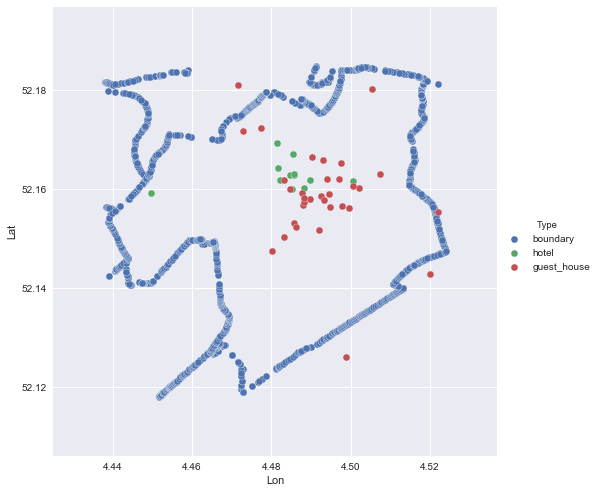

In [21]:
# create dataframe for the hotels
query = '''
SELECT 
  lat, lon, value
FROM 
  (SELECT 
     nodes.lat, nodes.lon, hotels.value 
   FROM 
     nodes 
   INNER JOIN 
     (SELECT id, value FROM nodes_tags WHERE key = "tourism" AND 
      (value = "hotel" OR value="guest_house" OR value="hostel" OR value="motel")) as hotels 
   ON 
     nodes.id = hotels.id)
WHERE 
  (lat BETWEEN 52.118 AND 52.185) AND (lon BETWEEN 4.438 AND 4.524)
'''

c.execute(query)
results_hotels = c.fetchall()
df = pd.DataFrame(results_hotels)
df_hotels = df.rename(columns={0:"Lat",1: "Lon",2:"Type"})

# combine city boundary and hotel dataframes
df = df_city.append(df_hotels)
df_hotels_city = df.fillna('boundary')
df_hotels_city = df_hotels_city[(df_hotels_city.Lon>=4.438) & (df_hotels_city.Lon<=4.524) &\
               (df_hotels_city.Lat>=52.118) & (df_hotels_city.Lat<=52.185)]

# plot hotels and city boundaries
sns.pairplot(df_hotels_city, x_vars='Lon', y_vars='Lat', hue='Type', size=7, markers="o")
plt.show()

<p>As the city boundaries are not in the form of a rectangle, we can see that when we plot the hotels only 41 accommodations actually fall within the city boundaries. Most of the hotels are clustered in the center of the city as one can expect for a city in Europe.</p>
<p>In the past the city of Leiden was located within the <a href="https://nl.wikipedia.org/wiki/Singel_(gracht)">singels</a> (canals). The singels are man made waterways that were part of the defense of the fortified system. The singel system was finished in <a href="https://nl.wikipedia.org/wiki/Leiden">1659</a>. Until today the city center is perceived as lying within the singels. The white area in the image below, where the surrounding blue lines show the singels.</p> <img src='Leiden_Annexaties.jpg',width=300,height=300>

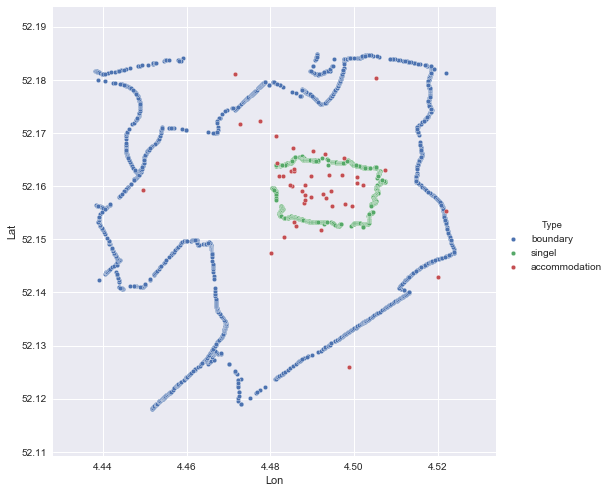

In [22]:
# find the singels
query = '''
SELECT 
  nodes.lat, nodes.lon
FROM 
  (SELECT 
     * 
   FROM 
     nodes_tags 
   WHERE 
     key = 'street' AND (value="Zoeterwoudsesingel" OR value ='Witte Singel' OR value='Zijlsingel' OR 
     value='Rijnsburgersingel' OR value='Maresingel' OR value='Herensingel' OR value='Morssingel' )) as kv
LEFT JOIN 
  nodes
ON 
  kv.id = nodes.id
'''

c.execute(query)
results = c.fetchall()
df = pd.DataFrame(results)
df['Type'] = 'singel'
df_singels = df.rename(columns={0:"Lat",1: "Lon"})

# combine city boundaries and singels data
df_leiden['Type'] = 'boundary'
df_leiden_singels = df_leiden.append(df_singels)
df_leiden_singels = df_leiden_singels[(df_leiden_singels.Lon>=4.438) & (df_leiden_singels.Lon<=4.524) &\
               (df_leiden_singels.Lat>=52.118) & (df_leiden_singels.Lat<=52.185)]

# add the hotel data
df_acc = df_hotels[['Lat', 'Lon']]
df_acc['Type'] = 'accommodation'
df_leiden_singels_acc = df_leiden_singels.append(df_acc)

sns.pairplot(df_leiden_singels_acc, x_vars='Lon', y_vars='Lat', hue='Type', size=7, plot_kws={"s": 20})
plt.show()

<p>As expected most of the accomodations lies within the singels of Leiden.</p>

<h1>Dataset improvements</h1>
<p>Going through data wrangling and analysis process I came across a number of things were the OpenStreetMap dataset could use some improvement.</p>
<h2>Sources</h2>
<p>When looking at the sources I found that for a the majority of the entries of the top 10 contributors no source was indicated. For only 22,3% of the the Leiden database source tags are available. As noted nodes do not necessarily need tags as they can be part of a way or relations, but it would be interesting to see where this information is coming from.</p>
<p>Another thing I came across that requires cleaning is that sometimes the source value holds multiple sources. Having one source per tag would be cleaner and managable to clean up as most used semi colons to separate the different sources.</p>

In [23]:
# find total number of ways and nodes in database
query_total = 'SELECT count(*) FROM (SELECT id FROM nodes UNION ALL SELECT id FROM ways)'
c.execute(query_total)
results_total = c.fetchall()

# find the number of nodes and ways that have a source tag
query = '''
SELECT 
  count(*)
FROM
  (SELECT * FROM ways_tags UNION ALL SELECT * FROM nodes_tags) 
WHERE 
  key = 'source'
'''

c.execute(query)
results=c.fetchall()

print "% of nodes and ways that have a source tag:", \
  round((results[0][0]) / float(results_total[0][0]),4)

% of nodes and ways that have a source tag: 0.2234


<h2>Addresses</h2>
<p>It is clear from the accommodation analysis that there is missing data. For many accommodations there are no tags that host their postcode or city. The same is true for missing addresses and phone numbers tags. This is important information if you want to contact these accomodations. The lat and lon coordinates are available so it seems that at least the address tags could be fixed programmatically as you can determine address, city and postcode by lat and lon coordinates.</p>

<h2>Missing hotels</h2>
<p>I further came to the conclusion that not all hotels in Leiden are available. For example, the Holiday Inn in Leiden is not found. The busstops in front of the hotel are however available. As the Holiday Inn was opened in <a href="https://www.leidschdagblad.nl/leiden-en-regio/chinezen-kopen-holiday-inn-leiden">1968 as the first Holiday Inn on the European mainland</a>, you would expect it to show up. Some hotels that have been opened in the recent years are available (Boutique Hotel d'Oude Morsch) while others are missing (City Resort). A crosscheck with other available sources (like <a href="https://www.booking.com/searchresults.html?aid=336408&label=leiden-eQY7Tt_tNuHhM*fOEHaJyQS201212258357%3Apl%3Ata%3Ap135%3Ap2%3Aac%3Aap1t1%3Aneg%3Afi%3Atiaud-285284111246%3Akwd-12082263405%3Alp9032131%3Ali%3Adec%3Adm&sid=47e09a33541d6055c22d59c7fb294706&sb=1&src=city&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Fcity%2Fnl%2Fleiden.html%3Faid%3D336408%3Blabel%3Dleiden-eQY7Tt_tNuHhM%252AfOEHaJyQS201212258357%253Apl%253Ata%253Ap135%253Ap2%253Aac%253Aap1t1%253Aneg%253Afi%253Atiaud-285284111246%253Akwd-12082263405%253Alp9032131%253Ali%253Adec%253Adm%3Bsid%3D47e09a33541d6055c22d59c7fb294706%3Binac%3D0%26%3B&ssne=Leiden&ssne_untouched=Leiden&city=-2148516&checkin_month=&checkin_monthday=&checkin_year=&checkout_month=&checkout_monthday=&checkout_year=&room1=A%2CA&no_rooms=1&group_adults=2&group_children=0&genius_rate=1">Booking.com</a> or <a href="https://www.kvk.nl/zoeken/handelsregister/#!uitgebreid-zoeken&handelsnaam=hotel&kvknummer=&straat=&postcode=&huisnummer=&plaats=Leiden&hoofdvestiging=true&rechtspersoon=true&nevenvestiging=true&zoekvervallen=0&zoekuitgeschreven=1&start=10&initial=0&searchfield=uitgebreidzoeken">Chamber of Commerce listings</a>) would make sure that missing entries can be added. In the case of hotels these would not change very often so a check once every year would be sufficient.</p>

In [24]:
# searching for the Holiday Inn
query1 = '''
SELECT
  names.id, hotel, nodes_tags.value
FROM
  nodes_tags
INNER JOIN
  (SELECT
     id, value as hotel
   FROM
     nodes_tags
   WHERE 
     id IN (SELECT id FROM nodes_tags WHERE key='name' AND value LIKE "%Holiday Inn%") AND key='name') as names
ON
  names.id = nodes_tags.id
WHERE
  key='highway'
'''

c.execute(query1)
results=c.fetchall()
df = pd.DataFrame(results)
df = df.rename(columns={0:"ID",1: "Name",2:"Type"})
df

,ID,Name,Type
0,1699280503,Holiday Inn,bus_stop
1,1699280545,Holiday Inn,bus_stop


In [25]:
# find names of hotels in Leiden
query = '''
SELECT
  value
FROM
  nodes_tags
WHERE id IN
(SELECT 
     hotels.id 
FROM 
     nodes 
INNER JOIN 
     (SELECT id, value FROM nodes_tags WHERE key = "tourism" AND value = "hotel" ) as hotels 
ON 
    nodes.id = hotels.id
WHERE 
  (lat BETWEEN 52.118 AND 52.185) AND (lon BETWEEN 4.438 AND 4.524)) 
AND key='name' 
  '''

c.execute(query)
results = c.fetchall()
df = pd.DataFrame(results)
#df

<h1>Conclusion</h1>
<p>Compared to the US dataset we wrangled in the case study, it appears to me that the data for Leiden and its surroundings is much cleaner and more consistent. This is probably partly due by the fact that a handful of users provided most of the information and used already existing databases for which import format guidelines were in place. That said obvious places (like fe Holiday Inn) are missing and data is incomplete (missing city, addresses, postcode, phone tags).</p>  

<h1>Sources</h1>
<p>Next to the links referred to in the text, I have also made use of:</p>
<ul>
<li>Wiki OpenStreetMap, different sections</li>
<li>Wikipedia, pages on Leiden and singels (unfortunately most pages were only available in Dutch)</li>
<li>Stackoverflow</li>
<li>Udacity forum and example project</li>
<li>Python, matplotlib and seaborn sites</li>
</ul>